# Generate Feature Matrices and Modeling

In [4]:
import os
os.chdir(os.path.dirname('/Users/shristi/Documents/InsightDataProject/PythonScripts/'))

import importlib
import read_all_data
importlib.reload(read_all_data)
import re
import numpy as np
import pandas as pd
from read_all_data import read_data, Drug, cleanup_data, cleanup_interactions
import pickle
import relation
import featurize
importlib.reload(featurize)
from featurize import get_profile, compute_similarity, featurize_smiles_mol_fingerprint_drug, featurize_smiles_mol_fingerprint_all_pairs, find_structure_in_list, get_label_map
import sklearn
from sklearn.model_selection import train_test_split


In [6]:
xmlfile = '/Users/shristi/Documents/InsightDataProject/Data/DrugBank/fulldatabase2.xml'
drug_list = read_data(xmlfile)
drug_list = cleanup_data(drug_list)

## Generate the relation types across the drug pairs

In [7]:
importlib.reload(relation)
from relation import get_relations_for_drug_list, filter_unknown_relations
relations = get_relations_for_drug_list(drug_list)
relations = filter_unknown_relations(relations)

### Analyze relation types

#### Asymmetry in interactions: 

The interaction relation between drug pairs is stored as follows in the relations class. Interactions between drugs could be symmetric and asymmetric. All the drug interaction pairs in drugbank are asymmetric where the effect of one drug (subject) is exerted upon the other(object). Hence, these relations are extracted in the script relations.py and each relation is normalized into clusters of normalized relations.

In [8]:
relations[1]

Subject:abciximab
Original Description:abciximab may increase the anticoagulant activities of bivalirudin.
Description:may increase the anticoagulant activities of
Normalized:increase anticoagulant activities
Object:bivalirudin

#### Check if (drug1, drug2) interaction is the same as (drug2, drug1): 

If this is true, both pairs should be included in the training but if not only single pair can be included for training.

In [50]:
labels = {}
same = []
different = []
for relation in relations: 
    drug_pair = (relation.subject, relation.object)
    interaction = relation.normalizedRelation
    if drug_pair in labels.keys():
        #print("Drug pair", drug_pair)
        #print("Current Interaction", interaction)
        #print("Interaction existing in dictionary", labels[drug_pair])
        if interaction == labels[drug_pair]:
            same.append((drug_pair, "SAME INTERACTION"))
        else:
            different.apppend((drug_pair, "DIFFERENT INTERACTION"))
    else: 
        labels[drug_pair] = interaction
    
print("Instances where the relations are Same, Different: ", len(same),",", len(different))

Instances where the relations are Same, Different:  208097 , 0


#### Check the distribution of normalized relations among the available interactions to check for class imbalance

In [51]:
label_types = {}
for label in labels:
    interaction = labels[label]
    if interaction in label_types.keys(): 
        value = label_types[interaction]
        label_types[interaction] = value + 1
    else: 
        label_types[interaction] = 1

In [52]:
label_types_df = pd.DataFrame(label_types.items(), columns = ['Relations', 'Frequency'])
label_types_df.sort_values(by = ['Frequency'], ascending = False, inplace = True)
label_types_df.head()
label_types_df= label_types_df[label_types_df.Frequency >300] # remove interactions that have fewer than 300 samples in total

In [53]:
label_types_df.shape

(40, 2)

Text(0.5, 1.0, 'Number of samples per class')

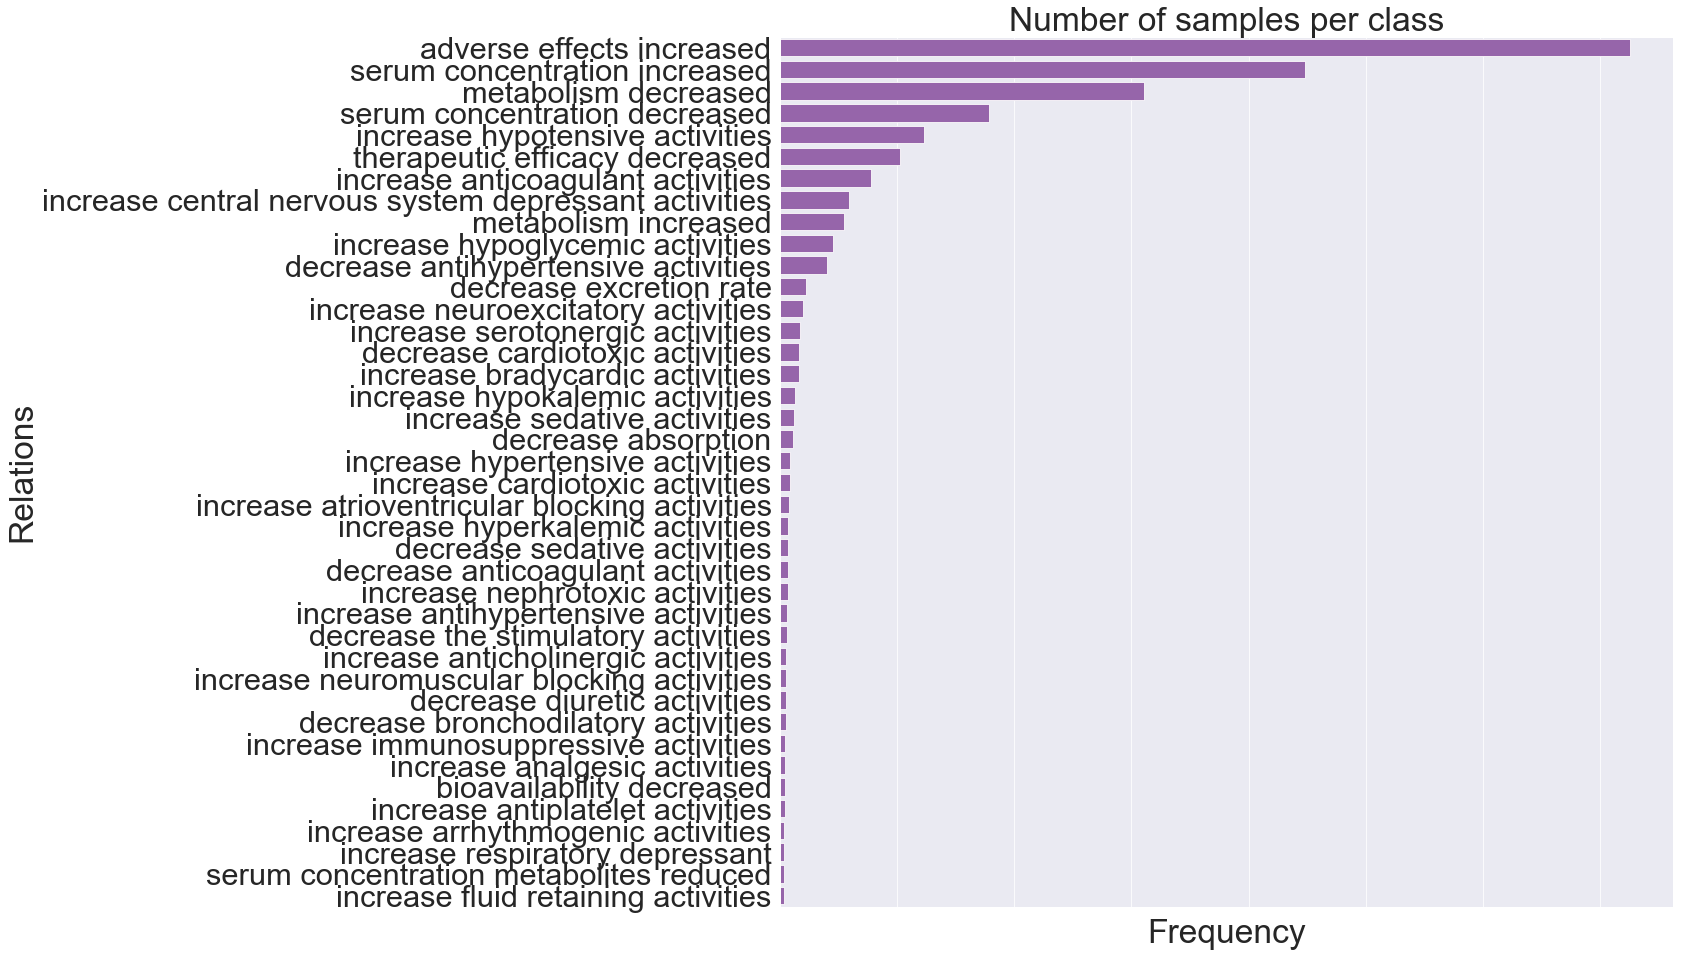

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (16,16))
sns.set(rc={'figure.figsize':(14.5,11.27)})
#sns.set(font= 14)
sns.set_context("paper", font_scale=3.5)                                                  
g = sns.barplot(x = 'Frequency', y = 'Relations', data = label_types_df,  color = "#9b59b6")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Number of samples per class")


In [55]:
selected_labels= {} # selected based on how frequent a particular interaction is 
selected_label_descriptions = list(label_types_df['Relations'])# taken > 300 frequency from the dataframe above

for drug_pair in labels: 
    if labels[drug_pair] in selected_label_descriptions: 
        value = labels[drug_pair]
        selected_labels[drug_pair] = value
    else: 
        continue
        

# Models for prediction

In [56]:
x_features, y_label, z_drug_pairs  = featurize_smiles_mol_fingerprint_all_pairs(selected_labels, drug_list)


In [57]:
# for doing train test split on the 
import random
def get_split_idx(n, train_fraction):
    indices = list(range(n))
    random.shuffle(indices)
    ntrain = int(train_fraction*len(indices))
    return indices[:ntrain], indices[ntrain:]

def get_subarray(arr, idx):
    ret = []
    for i in idx:
        ret.append(arr[i])
    return ret

In [58]:
train_idx, test_idx = get_split_idx(len(x_features), 0.85)
x_train = get_subarray(x_features, train_idx)
x_test = get_subarray(x_features, test_idx)

y_train = get_subarray(y_label, train_idx)
y_test = get_subarray(y_label, test_idx)

z_train = get_subarray(z_drug_pairs, train_idx)
z_test = get_subarray(z_drug_pairs, test_idx)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_label, test_size = 0.2, random_state = 42, stratify = y_label)
z_train, z_test, y_train, y_test = train_test_split(z_drug_pairs, y_label, test_size = 0.2, random_state = 42, stratify = y_label)

## Random Forest

In [60]:
import modeling
importlib.reload(modeling)
from modeling import plot_confusion_matrix,get_reverse_label_map
from sklearn.ensemble import RandomForestClassifier
importlib.reload(featurize) 
from featurize import get_label_map
from joblib import dump, load


In [61]:
#rf = RandomForestClassifier(n_estimators=100, random_state=1123)
#rf.fit(x_train, y_train)
#dump(rf, '/Users/shristi/Documents/InsightDataProject/Models/RFmodel01.joblib') 
rf = load('/Users/shristi/Documents/InsightDataProject/Models/RFmodel01.joblib')


### Model Evaluation

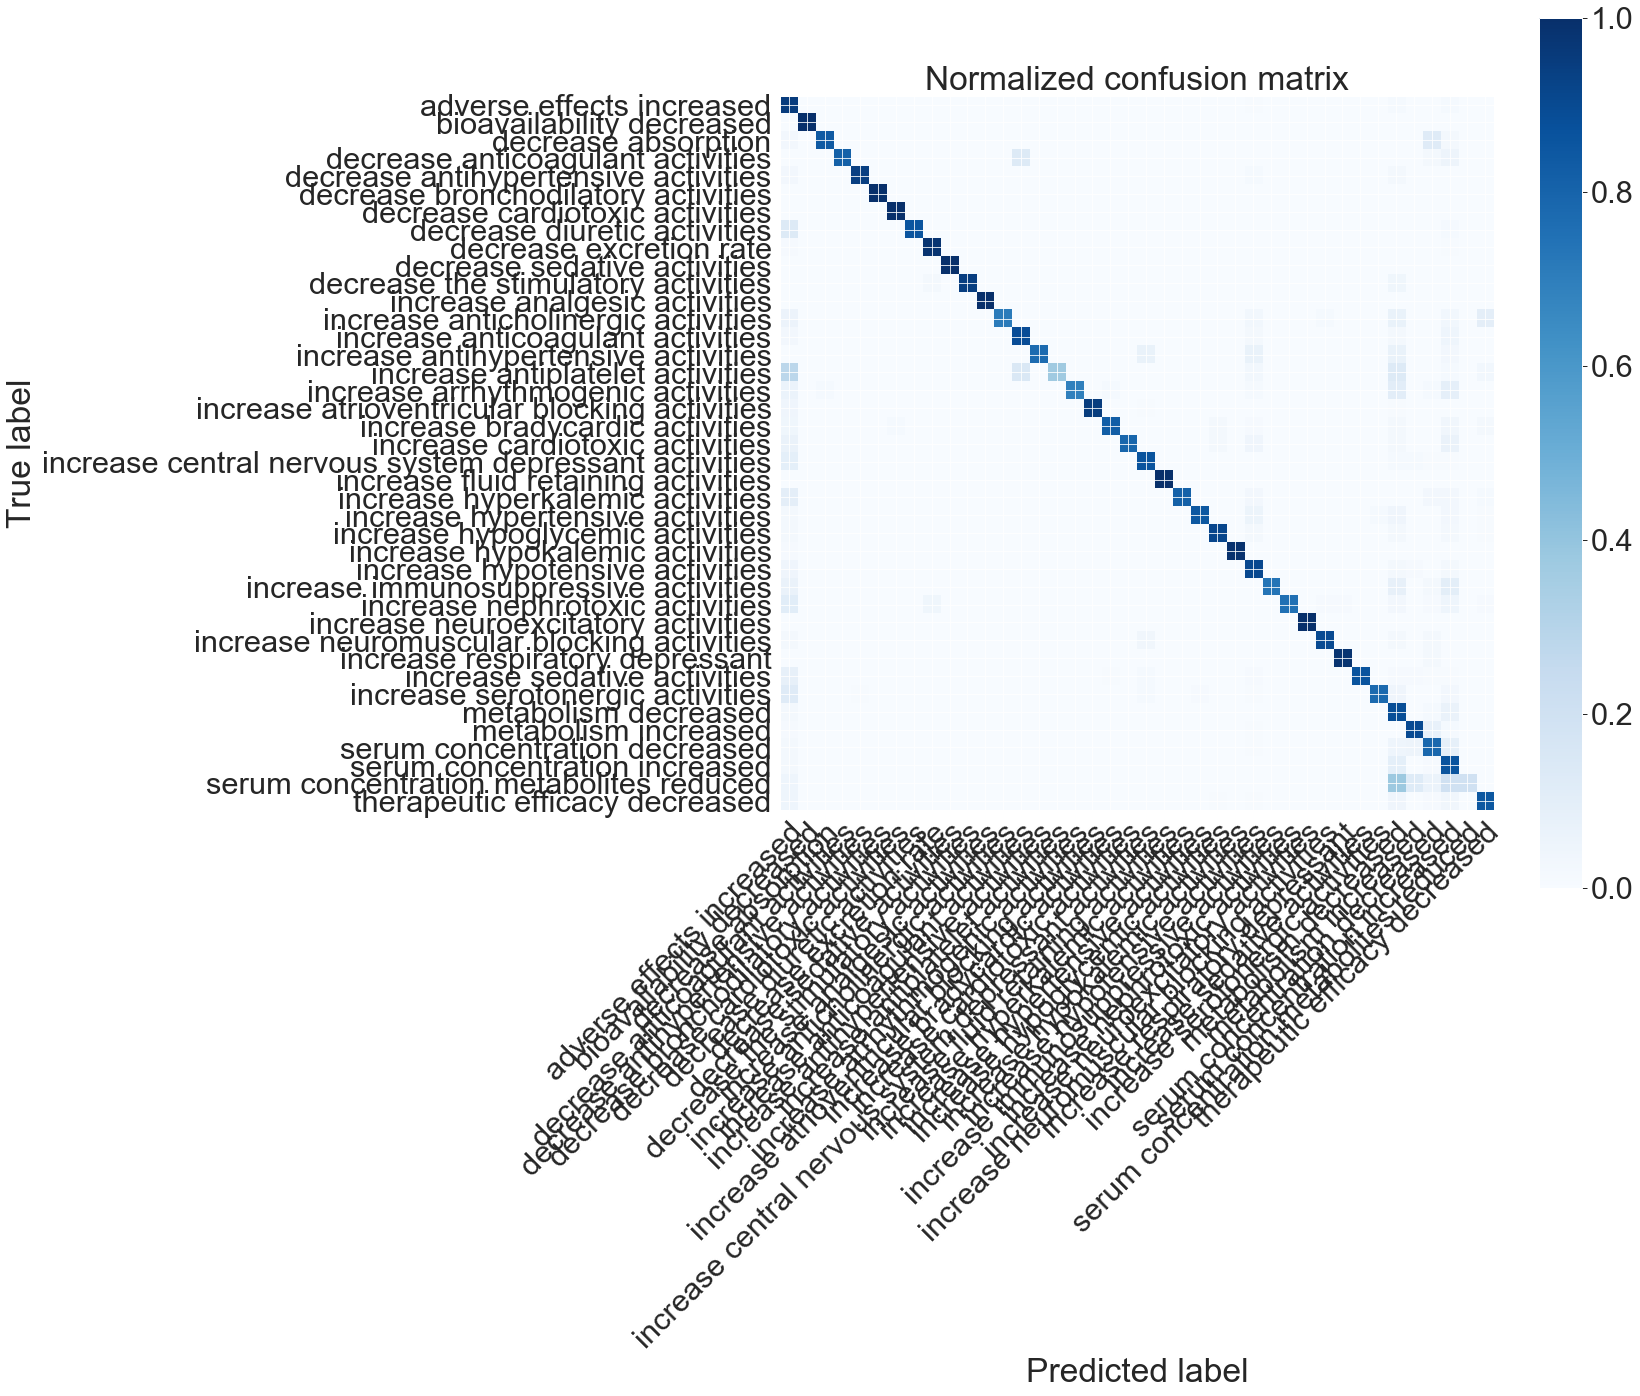

In [62]:
y_pred = rf.predict(x_test)
label_map = get_reverse_label_map(selected_labels)
class_names = np.array([i for i in range(40)])
str_class_names = []
for class_name in class_names: 
    str_name = label_map[class_name]
    str_class_names.append(str_name)
    
plot_confusion_matrix(y_test, y_pred, classes = class_names, names = str_class_names, normalize = True)

In [63]:
y_pred_proba = rf.predict_proba(x_test)
preds_0 = list(y_pred_proba[:,0])
true_0 = [1 if x == 0 else 0 for x in y_test]


In [64]:
print(preds_0[:20])
print(true_0[:20])

[0.08, 0.96, 0.92, 0.01, 0.03, 0.96, 0.06666666666666667, 0.95, 0.28, 0.02, 0.01, 0.05, 0.93, 0.06, 0.02, 0.42, 0.58, 0.02, 0.0, 0.98]
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


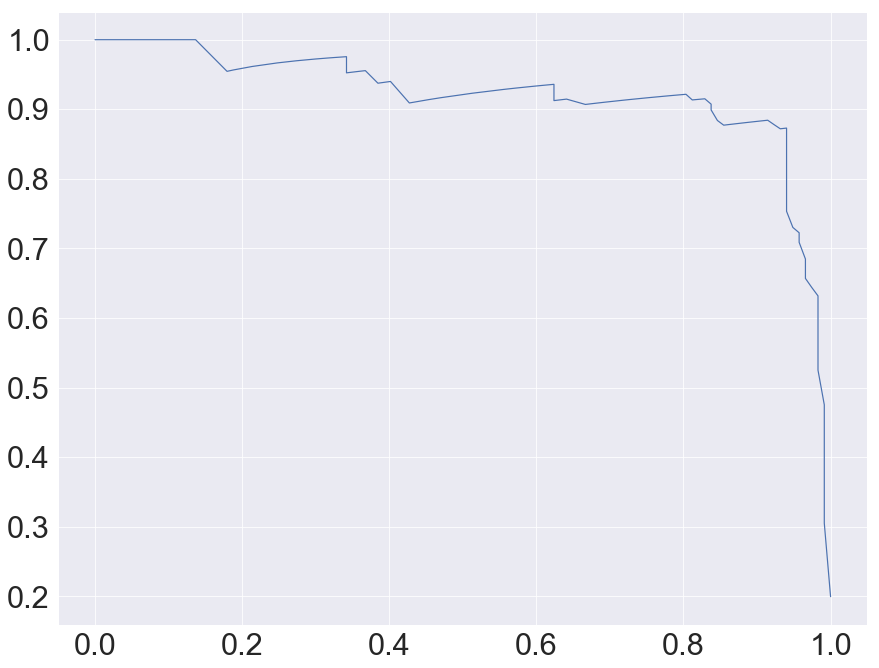

In [65]:
from sklearn.metrics import precision_recall_curve
import pylab as plt

test_class = 2
preds_2 = list(y_pred_proba[:,test_class])
true_2 = [1 if x == test_class else 0 for x in y_test]
for i in range(len(true_2)):
    if true_2[i] == 0:
        preds_2[i] = preds_2[i]

'''
count = 0
for i in range(len(preds_2)):
    if true_2[i] == 1:
        print("true:%d, prob:%.3f" % (1, preds_2[i]))
        count += 1
    if count == 10:
        break
'''

precision, recall, thresholds = precision_recall_curve(true_2, preds_2, 1)
plt.plot(recall, precision)


In [66]:
import modeling
importlib.reload(modeling)
from modeling import generate_model_report

In [67]:
generate_model_report(rf, x_test, y_test)

Accuracy:  0.8920541552222844
Precision:  0.893982092814918
Recall:  0.8920541552222844
F1 Score:  0.8915066802084256


In [68]:
import modeling 
importlib.reload(modeling)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from modeling import get_reverse_label_map, generate_model_report, convert_to_2_class_proba, convert_to_2_class, draw_pr_curves, generate_model_report_per_class

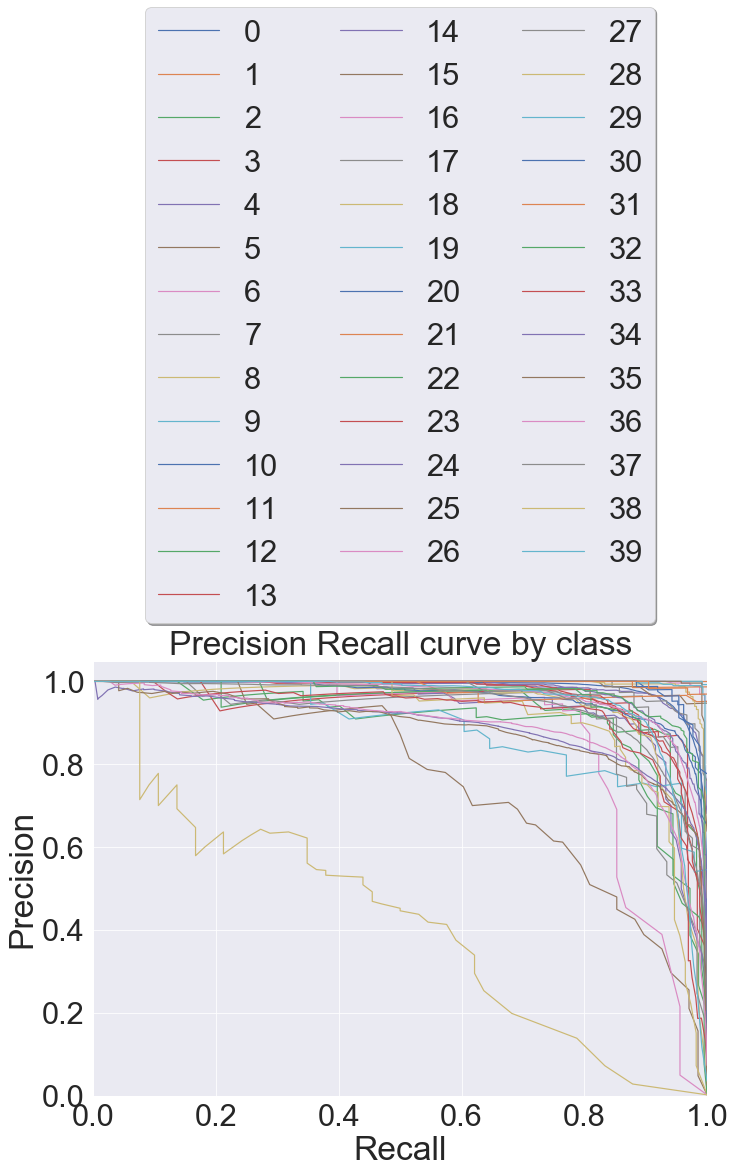

In [69]:
classes = list(set(y_test))
draw_pr_curves(y_test, y_pred_proba, classes)


In [70]:
accuracy_per_class, precision_per_class, recall_per_class, f1score_per_class = generate_model_report_per_class(rf, y_test, rf.predict(x_test),classes)


In [71]:
label_map

{0: 'adverse effects increased',
 1: 'bioavailability decreased',
 2: 'decrease absorption',
 3: 'decrease anticoagulant activities',
 4: 'decrease antihypertensive activities',
 5: 'decrease bronchodilatory activities',
 6: 'decrease cardiotoxic activities',
 7: 'decrease diuretic activities',
 8: 'decrease excretion rate',
 9: 'decrease sedative activities',
 10: 'decrease the stimulatory activities',
 11: 'increase analgesic activities',
 12: 'increase anticholinergic activities',
 13: 'increase anticoagulant activities',
 14: 'increase antihypertensive activities',
 15: 'increase antiplatelet activities',
 16: 'increase arrhythmogenic activities',
 17: 'increase atrioventricular blocking activities',
 18: 'increase bradycardic activities',
 19: 'increase cardiotoxic activities',
 20: 'increase central nervous system depressant activities',
 21: 'increase fluid retaining activities',
 22: 'increase hyperkalemic activities',
 23: 'increase hypertensive activities',
 24: 'increase hyp

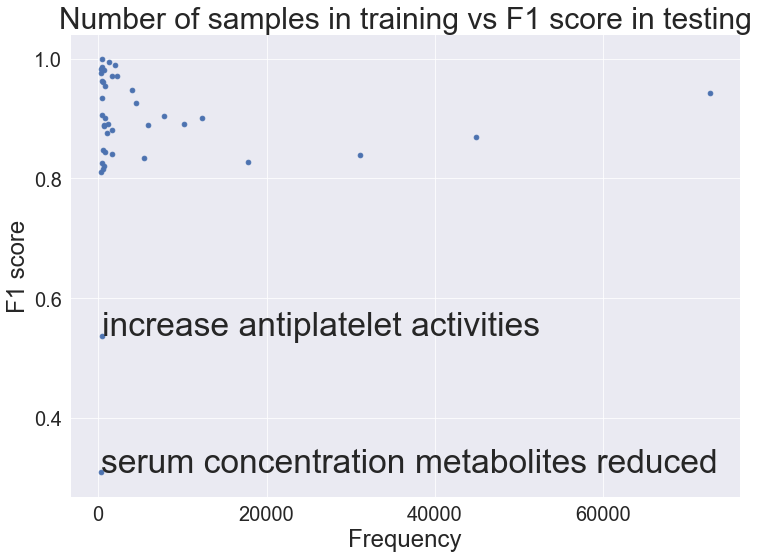

In [72]:
label_map = get_label_map(selected_labels)
reverse_label_map = {v:k for k, v in label_map.items()}
freq = []
accuracy = []
labels = []
precision = []
f1score = []
for label in reverse_label_map: 
    #print(label)
    curr_label = reverse_label_map[label]
    labels.append(curr_label)
    freq.append(label_types[curr_label])
    accuracy.append(accuracy_per_class[label])
    precision.append(precision_per_class[label])
    f1score.append(f1score_per_class[label])
    
fig, ax = plt.subplots(figsize = (12, 8.5))
 
ax.scatter(freq, f1score)
ax.set_xlabel('Frequency', fontsize = 24)
ax.set_ylabel('F1 score', fontsize = 24)
ax.set_title('Number of samples in training vs F1 score in testing', fontsize = 30)

label_points = ['increase antiplatelet activities', 'serum concentration metabolites reduced']
for i, txt in enumerate(labels):
    if txt in label_points:
        ax.annotate(txt, (freq[i], f1score[i]))
        
    
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)


### Check for Data Leakage through extreme structural similarity

In [73]:
import modeling
importlib.reload(modeling)
from featurize import compute_similarity, calculate_tanimoto_similarity
from modeling import get_smiles
import pickle
from pickle import dump, load

In [74]:
# make a name to smiles dictionary
name_to_smiles ={}
for elem in drug_list:
    name_to_smiles[elem.name] = elem.structure

In [75]:
#tanimotos = {}
#for elem in list(selected_labels.keys()): 
#    smiles_pair = get_smiles(elem, name_to_smiles)
#    if smiles_pair is not None:
#        profile1 = get_profile(smiles_pair[0])
#        profile2 = get_profile(smiles_pair[1])
#        if profile1 is not None and profile2 is not None:
#            tanimotos[elem] = compute_similarity(profile1, profile2)            
#with open('tanimotos.pickle', 'wb') as handle:
#    pickle.dump(tanimotos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
os.chdir(os.path.dirname('/Users/shristi/Documents/InsightDataProject/Data/ProcessedData/'))
with open('tanimotos.pickle', 'rb') as handle:
    tanimotos = pickle.load(handle)

Text(0, 0.5, 'Count')

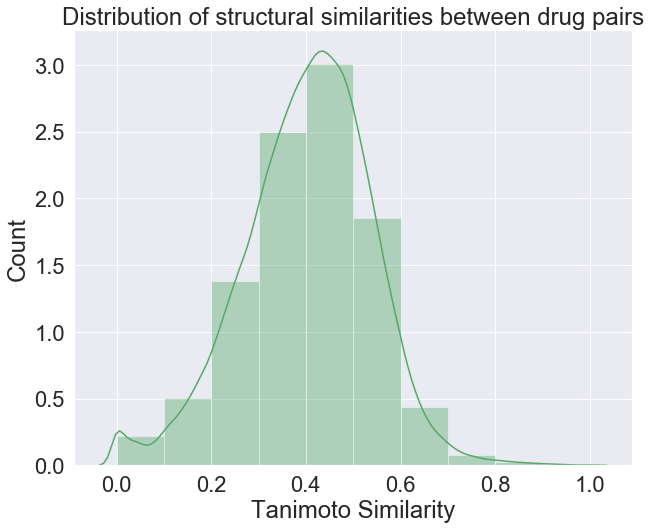

In [80]:
import seaborn as sns

sns.set(font_scale=2)
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.distplot(np.array(list((tanimotos.values()))), color="g", bins = 10)
ax.set_title("Distribution of structural similarities between drug pairs")
ax.set_xlabel("Tanimoto Similarity")
ax.set_ylabel('Count')



In [81]:
tanimotos_9_to_10 = {}
for key in tanimotos:
    val = tanimotos[key]
    if val > 0.85:
        tanimotos_9_to_10[key] = val
        
print(len(selected_labels))
entities_to_remove = list(tanimotos_9_to_10.keys())
selected_labels_filtered = {} # filtered very similar structures to prevent data leakage in the model
for key in selected_labels:
    #print(key)
    if key in entities_to_remove:
        continue
    else:
        val = selected_labels[key]
        selected_labels_filtered[key] = val

len(selected_labels_filtered)
a = list(tanimotos_9_to_10.keys())

240882


In [82]:
import rdkit
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.Chem import Draw

smiles_pair = get_smiles(a[2], name_to_smiles)
template1 = get_profile(smiles_pair[0])
AllChem.Compute2DCoords(template1)

template2 = get_profile(smiles_pair[1])
AllChem.Compute2DCoords(template2)

Draw.MolToFile(template1,'template1.o.png')
Draw.MolToFile(template2,'template2.o.png')

#AllChem.GenerateDepictionMatching2DStructure(template1, template2)

In [83]:
x_f, y_l, z_d_pairs  = featurize_smiles_mol_fingerprint_all_pairs(selected_labels_filtered, drug_list)
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(x_f, y_l, test_size = 0.2, random_state = 42, stratify = y_l)
y_train_f, y_test_f, z_train_f, z_test_f = train_test_split(y_l, z_d_pairs, test_size = 0.2, random_state = 42, stratify = y_l)

In [92]:
import joblib
from sklearn.ensemble import RandomForestClassifier
#rf_filtered = RandomForestClassifier(n_estimators=50, random_state=1123)
#rf_filtered.fit(x_train_f, y_train_f)
#joblib.dump(rf_filtered, '/Users/shristi/Documents/InsightDataProject/Models/RFmodel02_filtered.joblib')
rf_filtered = joblib.load('/Users/shristi/Documents/InsightDataProject/Models/RFmodel02_filtered.joblib')

In [93]:
rf_filtered.score(x_test_f, y_test_f)

0.28041478019570615

In [71]:
rf_filtered_cv = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=42,
    class_weight='balanced'
)

In [65]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf_random = RandomizedSearchCV(estimator = rf_filtered_cv, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train_f, y_train_f)

NameError: name 'max_depth' is not defined

### Feature Importance

In [122]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

(array([2.219e+03, 8.420e+02, 4.020e+02, 2.060e+02, 1.150e+02, 9.200e+01,
        4.400e+01, 4.000e+01, 2.900e+01, 3.000e+01, 2.100e+01, 1.500e+01,
        1.000e+01, 1.000e+01, 3.000e+00, 4.000e+00, 7.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00014336, 0.00028673, 0.00043009, 0.00057346,
        0.00071682, 0.00086019, 0.00100355, 0.00114692, 0.00129028,
        0.00143365, 0.00157701, 0.00172038, 0.00186374, 0.00200711,
        0.00215047, 0.00229384, 0.0024372 , 0.00258057, 0.00272393,
        0.0028673 , 0.00301066, 0.00315403, 0.00329739, 0.00344076,
        0.00358412, 0.00372749, 0.00387085, 0.00401422, 0.00415758,
        0.00430095]),
 <a list of 30 Patch objects>)

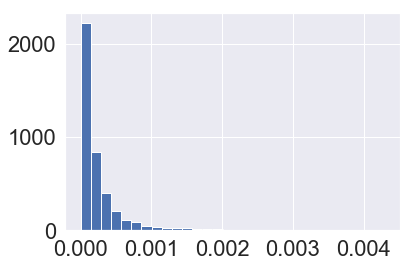

In [123]:
rf.feature_importances_
plt.hist(np.abs(rf.feature_importances_), bins=30)

In [124]:
index1 = np.where(np.abs(rf.feature_importances_) > 0.002)
index1 = index1[0]

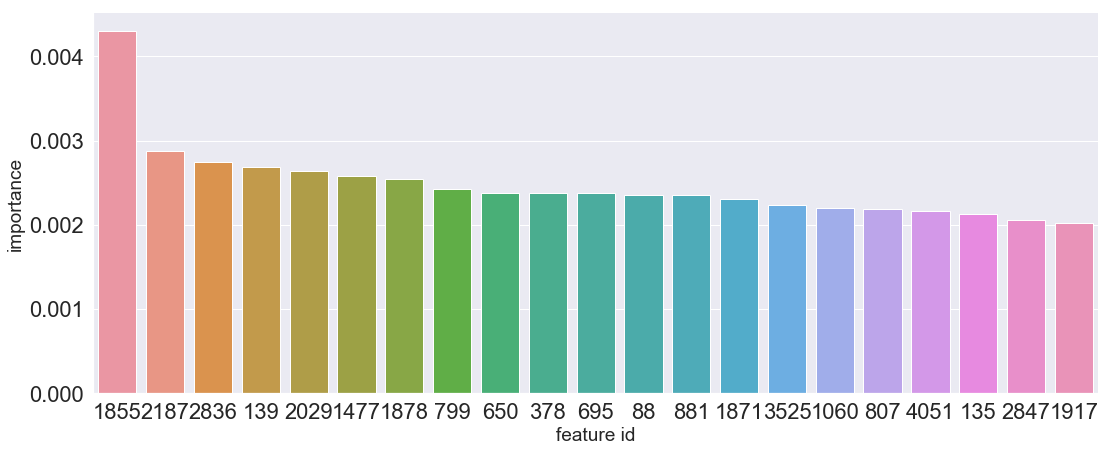

In [126]:
importance_df = pd.DataFrame()
importance_df['id'] = index1
importance_df['importance'] = rf.feature_importances_[index1]
importance_df = importance_df.sort_values(by=['importance'], ascending=False)
importance_df
import seaborn as sns
plt.subplots(figsize=(18, 7))
ax = sns.barplot(x='id', y='importance', data=importance_df, order=importance_df['id'])
ax.set_xlabel("feature id", size=19)
ax.set_ylabel("importance", size=19)
sns.despine()

### Model Validation

In [ ]:
val_data = pd.read_csv("/Users/shristi/Documents/InsightDataProject/Data/Drugs.com/Drugsdotcom_val.csv")
val_drugs=list(val_data['DrugPair'])
val_drugs_lower = [x.lower() for x in val_drugs]

In [ ]:
#check if validation drugs are in the drug_list
drug_names = []
for drug in drug_list: 
    drug_names.append(drug.name)
    

In [ ]:
val_set = []
for val_drug in val_drugs_lower: 
    drug1 = val_drug.split(';')[0]
    drug2 = val_drug.split(';')[1]
    drug_pair = (drug1, drug2)
    val_set.append(drug_pair)

In [ ]:
import pickle
infile = open('/Users/shristi/Documents/InsightDataProject/Data/ProcessedData/fingerprints.pkl','rb')
fingerprints = pickle.load(infile)
fingerprints.index = fingerprints.index.str.lower()
name_to_smiles = fingerprints[['SMILES']]
name_to_fingerprints = fingerprints[['Molecular_Fingerprint']]

In [ ]:
name_to_smiles_dictionary = name_to_smiles.to_dict()
name_to_fingerprints_dictionary = name_to_fingerprints.to_dict()['Molecular_Fingerprint']


In [ ]:
a = predict(rf, ('levonorgestrel', 'lamotrigine'), name_to_fingerprints_dictionary)

In [ ]:
a = predict(rf, ('valsartan','amiloride'), name_to_fingerprints_dictionary)

In [ ]:
for key in name_to_fingerprints_dictionary:
    a = name_to_fingerprints_dictionary[key]
    

In [ ]:
import modeling
importlib.reload(modeling)
from modeling import predict
predictions = {}
for val_drug in val_set[1:57]:
    prediction = predict(rf, val_drug, name_to_fingerprints_dictionary)
    predictions[val_drug] = prediction
    

In [ ]:
# None of the validation drugs are in the drugset. SO now lets create a complete test set with these
predictions

In [47]:
label_map = get_label_map(selected_labels)
print(label_map)


{'adverse effects increased': 0, 'bioavailability decreased': 1, 'decrease absorption': 2, 'decrease anticoagulant activities': 3, 'decrease antihypertensive activities': 4, 'decrease bronchodilatory activities': 5, 'decrease cardiotoxic activities': 6, 'decrease diuretic activities': 7, 'decrease excretion rate': 8, 'decrease sedative activities': 9, 'decrease the stimulatory activities': 10, 'increase analgesic activities': 11, 'increase anticholinergic activities': 12, 'increase anticoagulant activities': 13, 'increase antihypertensive activities': 14, 'increase antiplatelet activities': 15, 'increase arrhythmogenic activities': 16, 'increase atrioventricular blocking activities': 17, 'increase bradycardic activities': 18, 'increase cardiotoxic activities': 19, 'increase central nervous system depressant activities': 20, 'increase fluid retaining activities': 21, 'increase hyperkalemic activities': 22, 'increase hypertensive activities': 23, 'increase hypoglycemic activities': 24, '

## Gradient Boosting

In [94]:
from numpy import loadtxt
from sklearn.ensemble import GradientBoostingClassifier

In [97]:
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(x_f, y_l, test_size = 0.2, random_state = 42, stratify = y_l)
y_train_F, y_test_f, z_train_f, z_test_f = train_test_split(y_l, z_d_pairs, test_size = 0.2, random_state = 42, stratify = y_l)

In [98]:
x_train_f = np.array(x_train_f)
x_test_f = np.array(x_test_f)

In [ ]:
n_samples = min(1000000, len(x_train_f))
gbt = GradientBoostingClassifier(random_state=1234)
gbt.fit(x_train_f[:n_samples], y_train_f[:n_samples])
dump(gbt, '/Users/shristi/Documents/InsightDataProject/Models/GBTmodel02.joblib')
gbt = load('/Users/shristi/Documents/InsightDataProject/Models/GBTmodel02.joblib')


In [ ]:
generate_model_report(gbt, x_test_f, y_test_f)

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

n_samples = min(1000000, len(x_train_f))
lr = LogisticRegression(random_state=1234)
lr.fit(x_train_f[:n_samples], y_train_f[:n_samples])
joblib.dump(lr, '/Users/shristi/Documents/InsightDataProject/Models/LRmodel01.joblib')
lr = joblib.load('/Users/shristi/Documents/InsightDataProject/Models/LRmodel01.joblib')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [42]:
generate_model_report(lr, x_test_f, y_test_f)

Accuracy:  0.9136604839102284
Precision:  0.9140990636866562
Recall:  0.9136604839102284
F1 Score:  0.9134662422465302


## Support Vector Machines

In [ ]:
from sklearn import svm


In [ ]:
svm_model = svm.SVC(gamma='scale', kernel='poly')
svm_model.fit(x_train, y_train) 